In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [ ]:
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
ratings = pd.read_csv('ratings.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Split the dataset to train and test parts

In [ ]:
#'ratings' is our DataFrame containing user ratings
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

We are going to use collaborative filtering

In [ ]:
# Convert the train ratings to a pivot table
train_pivot = train_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
train_pivot.head()

# Convert the test ratings to a pivot table
test_pivot = test_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
test_pivot.head()

movieId,1,2,3,5,6,7,8,9,10,11,...,183897,183959,184015,184931,185135,187593,189333,189547,189713,190215
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Convert the train pivot table to a numpy array
train_matrix = train_pivot.to_numpy()
train_matrix.shape

# Convert the test pivot table to a numpy array
test_matrix = test_pivot.to_numpy()
test_matrix.shape

(554, 4512)

In [ ]:
# Calculate the cosine similarity between users using the train matrix
user_similarity = cosine_similarity(train_matrix)
user_similarity.shape

(554, 554)

In [ ]:
train_matrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [ ]:
user_similarity

array([[1.        , 0.01631391, 0.04902077, ..., 0.23281083, 0.11217366,
        0.14390178],
       [0.01631391, 1.        , 0.        , ..., 0.05561043, 0.0324038 ,
        0.0758095 ],
       [0.04902077, 0.        , 1.        , ..., 0.00943339, 0.        ,
        0.03130872],
       ...,
       [0.23281083, 0.05561043, 0.00943339, ..., 1.        , 0.11037068,
        0.26088589],
       [0.11217366, 0.0324038 , 0.        , ..., 0.11037068, 1.        ,
        0.05797092],
       [0.14390178, 0.0758095 , 0.03130872, ..., 0.26088589, 0.05797092,
        1.        ]])

Make predictions

In [ ]:
def predict_user(ratings, similarity):
    # Calculate the mean rating for each user
    user_mean = ratings.mean(axis=1)
    # Subtract the mean rating from the original ratings
    ratings_diff = ratings - user_mean[:, np.newaxis]
    # Multiply the ratings difference with the similarity matrix and divide by the sum of similarities
    pred = user_mean[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

user_based_predictions = predict_user(train_matrix, user_similarity)
# Predict the ratings using user similarity
user_pred = predict_user(train_matrix, user_similarity)
user_pred.shape


(554, 8126)

In [ ]:
def evaluate(ratings, pred):
    # Flatten the ratings and predictions matrices to 1D arrays
    ratings = ratings.flatten()
    ratings = ratings[ratings.nonzero()]
    pred = pred.flatten()
    pred = pred[ratings.nonzero()]
    # Calculate RMSE and MAE using sklearn.metrics functions
    rmse = np.sqrt(mean_squared_error(ratings, pred))
    mae = mean_absolute_error(ratings, pred)
    return rmse, mae

# Evaluate the predictions using RMSE and MAE on the test matrix
rmse, mae = evaluate(test_matrix, user_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 3.6311
MAE: 3.4759


In [ ]:
def predict_for_user(user_id, user_based_predictions, user_item_matrix):
    # Get the ratings for the specified user
    user_ratings = user_item_matrix[user_id]

    # Get the predicted ratings for the user
    user_pred_ratings = user_based_predictions[user_id]

    # Combine actual ratings and predicted ratings into a DataFrame
    predictions_df = pd.DataFrame({'Actual_Rating': user_ratings, 'Predicted_Rating': user_pred_ratings})

    # Filter out movies that the user has not rated
    predictions_df = predictions_df[predictions_df['Actual_Rating'] > 0]
    predictions_df = predictions_df.sort_values(by='Predicted_Rating', ascending=False)
    return predictions_df

#Example: Get predictions for user 1
user_id_to_predict = 1
user_predictions = predict_for_user(user_id_to_predict, user_based_predictions, train_matrix)
print(user_predictions)

      Actual_Rating  Predicted_Rating
256             3.0          2.779388
5792            4.5          2.193785
6309            4.0          2.128015
2461            4.0          1.606486
1189            4.5          1.579230
4141            4.0          1.519823
5455            4.0          1.507831
6636            3.5          1.215516
6221            4.0          1.137161
7104            3.0          1.005428
7046            5.0          0.965126
7319            5.0          0.806580
6146            3.0          0.654716
7228            3.5          0.590676
6643            2.5          0.492775
6342            4.5          0.438998
6358            5.0          0.422870
5863            5.0          0.420358
268             4.0          0.358863
5409            4.0          0.305059
6577            5.0          0.300120
6270            3.0          0.221553
6486            4.0          0.208667
7429            5.0          0.143262
7199            2.0          0.053606


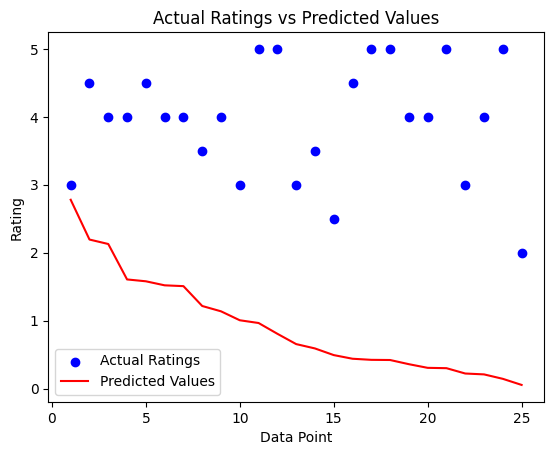

In [ ]:
# Create a scatter plot for actual ratings
plt.scatter(range(1, len(user_predictions.Actual_Rating) + 1), user_predictions.Actual_Rating, color='blue', label='Actual Ratings')

# Create a line plot for predicted values
plt.plot(range(1, len(user_predictions.Predicted_Rating) + 1), user_predictions.Predicted_Rating, color='red', label='Predicted Values')

# Set labels and title
plt.xlabel('Data Point')
plt.ylabel('Rating')
plt.title('Actual Ratings vs Predicted Values')
plt.legend()

# Show the plot
plt.show()